# Data Cleaning and Sentiment Analysis

In [84]:
import pandas as pd
import numpy as np

import re
import csv
import json
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict

import sys, getopt, pprint
from pymongo import MongoClient

from functions import make_dict, group_conversations

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

%reload_ext autoreload
%autoreload 2

### Connecting to AWS

In [68]:
config = {
  'host': 'xx.xx.xx.xxx:xxxxx',
  'username': 'username',
  'password': 'password',
  'authSource': 'customer_support_tweets'
}

client = MongoClient(**config)

In [83]:
db = client.customer_support_tweets

cursor = list(db.tweets.find({}, {'_id':0, 'tweet_id': 1, 'text': 1, 'author_id': 1, 'response_tweet_id': 1, 'in_response_to_tweet_id':1}))
cursor[0]

{'tweet_id': '1',
 'author_id': 'sprintcare',
 'text': '@115712 I understand. I would like to assist you. We would need to get you into a private secured link to further assist.',
 'response_tweet_id': '2',
 'in_response_to_tweet_id': '3'}

### Group Conversations

All of the rows in my dataset were individual tweets, so I first used the 'response_tweet_id' key and the 'in_response_to_tweet_id' key to group all tweets into a list for the full conversation. all_convos is a list of lists of conversations.

In [10]:
tweets_dict = make_dict()

In [60]:
all_convos = group_conversations(tweets_dict)

In [14]:
len(all_convos)

798198

In [17]:
with open('convo_texts.csv', 'w',newline='') as csvfile:
    file = csv.writer(csvfile)
    file.writerow(['tweet_ids', 'text'])
    
    for convo in all_convos:
        
        tweet_ids = ''
        full_convo = ''
        
        for tweet in convo:
            
            try:
                text = tweets_dict[tweet]['text']
                
                full_convo = full_convo + ' ' + text
                tweet_ids = tweet_ids + ' ' + tweet
            
            except:
                pass
                
        row = [tweet_ids, full_convo]
        file.writerow(row)

In [20]:
convosdf = pd.read_csv('convo_texts.csv')

In [21]:
convosdf.head()

,tweet_ids,text
0,1 2 3 4 5 6 7 8 9 10,@115712 I understand. I would like to assist ...
1,11 12 13 14 15 16 17 18,@115713 This is saddening to hear. Please sho...
2,19 20,@115715 Please send me a private message so t...
3,21 22 23 24 25 28 26 29 27,@115716 What information is incorrect? ^JK @A...
4,30 31,"@115717 Hello, My apologies for any frustrati..."


In [22]:
convosdf.text[1]

" @115713 This is saddening to hear. Please shoot us a DM, so that we can look into this for you. -KC @sprintcare You gonna magically change your connectivity for me and my whole family ? 🤥 💯 @115713 I would really like to work with you to have this resolved. Kindly send us a DM. I'm here for you! -ResolutionSup SR @115713 Hi, my name is Shantel, I'm a resolution supervisor here with Sprint. Your issues was brought to my attention.  1/2 -ResolutionSup SR @115713 We understand your concerns and we'd like for you to please send us a Direct Message, so that we can further assist you. -AA @sprintcare Since I signed up with you....Since day 1 @115713 H there! We'd definitely like to work with you on this, how long have you been experiencing this issue? -AA @115714 y’all lie about your “great” connection. 5 bars LTE, still won’t load something. Smh."

Removing twitter handles and urls from the conversations.

In [23]:
regex ="\B@\w+"
convosdf.text = convosdf.text.str.replace(regex, '')

In [24]:
regex = 'http\S+'
convosdf.text = convosdf.text.str.replace(regex, '')

### Customer Only Convos

First I will split out the customer and business tweets into separate data frames. I do not want to include the business tweets in the sentiment analysis since most are using the same language and they cloud the overall sentiment.

In [25]:
all_tweets = pd.read_pickle("./all_tweets.pkl")

non_business_tweets = all_tweets[all_tweets.author_id.str.contains('^[0-9]{2,6}$')]
business_tweets = pd.concat([all_tweets, non_business_tweets]).drop_duplicates(subset=['tweet_id'], keep=False)

In [28]:
len(non_business_tweets) + len(business_tweets) == len(all_tweets)

True

In [29]:
bus = business_tweets.author_id.value_counts().index.to_list()
non = non_business_tweets.author_id.value_counts().index.to_list()

In [32]:
regex ="\B@\w+"
non_business_tweets.text = non_business_tweets.text.str.replace(regex, '')

In [31]:
regex = 'http\S+'
non_business_tweets.text = non_business_tweets.text.str.replace(regex, '')

In [33]:
non_business_tweets = non_business_tweets.fillna('0')

non_business_tweets['in_response_to_tweet_id'] = pd.to_numeric(non_business_tweets['in_response_to_tweet_id'], downcast='integer')
non_business_tweets['in_response_to_tweet_id'] = non_business_tweets['in_response_to_tweet_id'].astype(str)
non_business_tweets['response_tweet_id'] = non_business_tweets['response_tweet_id'].astype(str)
non_business_tweets['tweet_id'] = non_business_tweets['tweet_id'].astype(str)

In [34]:
cust_dict = OrderedDict()

for index,row in non_business_tweets.iterrows():
    tweet_id = non_business_tweets.tweet_id[index]
    cust_dict[tweet_id] = {'tweet_id': non_business_tweets.tweet_id[index], 'author_id': non_business_tweets.author_id[index], 
                               'response_tweet_id': non_business_tweets.response_tweet_id[index], 
                               'in_response_to_tweet_id': non_business_tweets.in_response_to_tweet_id[index], 
                               'text': non_business_tweets.text[index]}

In [35]:
cust_convos = all_convos[1:]

for convo in cust_convos:
    for tweet in convo:
        if not tweet in cust_dict.keys():
            convo.remove(tweet)

In [36]:
with open('cust_texts.csv', 'w',newline='') as csvfile:
    file = csv.writer(csvfile)
    file.writerow(['tweet_ids', 'text'])
    
    for convo in cust_convos:
        
        tweet_ids = ''
        cust_convo = ''
        
        for tweet in convo:
            
            try:
                text = cust_dict[tweet]['text']
                
                cust_convo = cust_convo + ' ' + text
                tweet_ids = tweet_ids + ' ' + tweet
            
            except:
                pass
                
        row = [tweet_ids, cust_convo]
        file.writerow(row)

In [37]:
custdf = pd.read_csv("cust_texts.csv")

custdf = custdf.dropna()

### Data Cleaning

In [44]:
handles = []

for index, row in non_business_tweets.iterrows():
    try:
        handle = re.findall('\B@\w+', non_business_tweets.text[index])[0]
    except:
        handle = np.nan
        
    handles.append(handle)

In [45]:
non_business_tweets['company'] = handles

non_business_tweets['in_response_to_tweet_id'] = pd.to_numeric(non_business_tweets['in_response_to_tweet_id'], downcast='integer')
non_business_tweets['in_response_to_tweet_id'] = non_business_tweets['in_response_to_tweet_id'].astype(str)
non_business_tweets['response_tweet_id'] = non_business_tweets['response_tweet_id'].astype(str)
non_business_tweets['tweet_id'] = non_business_tweets['tweet_id'].astype(str)

In [46]:
bus_dict = OrderedDict()

for index,row in business_tweets.iterrows():
    tweet_id = business_tweets.tweet_id[index]
    bus_dict[tweet_id] = {'tweet_id': business_tweets.tweet_id[index], 'author_id': business_tweets.author_id[index], 
                               'response_tweet_id': business_tweets.response_tweet_id[index], 
                               'in_response_to_tweet_id': business_tweets.in_response_to_tweet_id[index], 
                               'text': business_tweets.text[index]}

In [61]:
bus_convos = all_convos[1:]

In [73]:
handles = []
for idx, val in enumerate(bus_convos):
    for tweet in val:
        try:
            cust_dict[tweet]
        except:
            company = bus_dict[int(tweet)]['author_id']
            continue
    try:
        handles.append(company)
    except:
        handles.append(np.nan)

In [76]:
allNumbers = set(range(0, 798196))

for idx, row in custdf.iterrows():
    allNumbers.remove(idx)

In [77]:
missing_indices = list(allNumbers)
missing_indices = sorted(missing_indices)

for i in reversed(missing_indices):
    del handles[i]
    
missing = pd.DataFrame(missing_indices)
missing.to_pickle("./missing_indices.pkl")

In [78]:
custdf['company'] = handles

In [79]:
custdf.head()

,tweet_ids,text,compound,pos,neu,neg,company
0,2 3 5 7 8,and how do you propose we do that I have se...,-0.7430,0.000,0.844,0.156,sprintcare
1,12 16 18,You gonna magically change your connectivity...,-0.6908,0.000,0.853,0.147,sprintcare
2,20,"whenever I contact customer support, they te...",0.2144,0.085,0.915,0.000,sprintcare
3,22 23 24 26 29,Would you like me to email you a copy of one...,0.4871,0.079,0.888,0.034,Ask_Spectrum
4,31,"Yo , your customer service reps are super nic...",0.4102,0.132,0.868,0.000,Ask_Spectrum


In [80]:
custdf.to_pickle('./custdf_with_sentiment.pkl')

### Sentiment Analysis with VADER

In [40]:
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

In [41]:
compound_cust = []
pos_cust = []
neu_cust = []
neg_cust = []

for convo in custdf.text:
    compound_cust.append(sentiment_analyzer_scores(convo)['compound'])
    pos_cust.append(sentiment_analyzer_scores(convo)['pos'])
    neg_cust.append(sentiment_analyzer_scores(convo)['neg'])
    neu_cust.append(sentiment_analyzer_scores(convo)['neu'])

In [42]:
custdf['compound'] = compound_cust
custdf['pos'] = pos_cust
custdf['neu'] = neu_cust
custdf['neg'] = neg_cust

In [81]:
company_group = custdf.groupby('company')
sentiment_by_company = company_group.agg({'compound': 'mean', 'pos': 'mean', 'neg': 'mean', 'neu': 'mean'})
sentiment_by_company.nlargest(5, 'compound')

,compound,pos,neg,neu
company,,,,
Walmart,0.541894,0.264106,0.022513,0.712551
Kimpton,0.479000,0.224093,0.028604,0.747295
MOO,0.466144,0.226746,0.032363,0.740889
AskTigogh,0.302804,0.159236,0.053677,0.783966
AskVirginMoney,0.295229,0.154899,0.070068,0.775040


In [82]:
sentiment_by_company.nsmallest(5, 'compound')

,compound,pos,neg,neu
company,,,,
KFC_UKI_Help,-0.209909,0.066883,0.135804,0.794336
DunkinDonuts,-0.117570,0.092989,0.135158,0.771834
AsurionCares,-0.108782,0.085547,0.114180,0.798375
CenturyLinkHelp,-0.093917,0.086262,0.124752,0.787969
sprintcare,-0.086329,0.088491,0.128379,0.778188


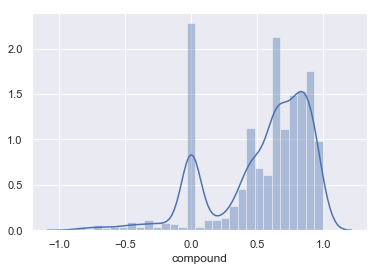

In [85]:
Walmart = custdf[custdf['company'] == 'Walmart']

sns.set()
sns.distplot(Walmart['compound']);

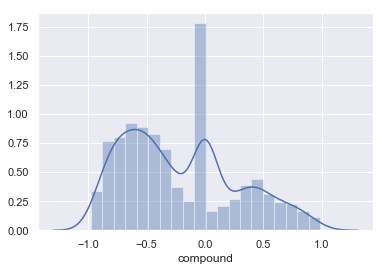

In [86]:
KFC = custdf[custdf['company'] == 'KFC_UKI_Help']

sns.set()
sns.distplot(KFC['compound']);